<div class="alert alert-block alert-info">
    
# Model 3: Pretrained Embedding as regression problem

https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

https://github.com/javaidnabi31/Word-Embeddding-Sentiment-Classification

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/?fbclid=IwAR1khMPlmKZhB9sW3y9kqmm3cYex6Rl5yDIyD8JGH677MJ5IP6wdmYoniZI

In [7]:
"""Module for loading the train and test data.

This module supports loading the data in two seperate ways.
The first, which is done by calling the load_train and load_test functions,
opens and parses the text files one by one. Because of the abundance of files,
this can take a while.
The second way of loading the data is by opening a pickle file containing the
results of the load_train and load_test functions. To create this pickle file,
call the create_data_pickle function once. Afterwards, you will be ablo to
quickly load the data using the load_data_pickle function.
"""
import collections
import glob
import os
import re
import warnings

#import utils


## Default data folder names ## 


DEFAULT_DATA_LOCATION = 'Data'
DEFAULT_TRAIN_DATA_LOCATION = os.path.join(DEFAULT_DATA_LOCATION, 'Train')
DEFAULT_TEST_DATA_LOCATION = os.path.join(DEFAULT_DATA_LOCATION, 'Test')

DEFAULT_PICKLE_PATH = os.path.join(DEFAULT_DATA_LOCATION, 'data.pkl')

PRICE_LOCATION_FILE_NAME = 'hotels.txt'
HOTEL_REVIEWS_FILE_TEMPLATE = 'Hotel_*.txt'
TEST_REVIEWS_FILE_TEMPLATE = '*.txt'


## Classes to store the parsed data in. ##


Hotel = collections.namedtuple(
  'Hotel', ['id', 'price', 'location'])
Review = collections.namedtuple(
  'Review', [
      'id', 'author', 'content', 'date', 'rating', 'subratings', 'hotel'])
Subratings = collections.namedtuple(
  'Subratings', [
      'value', 'rooms', 'location', 'cleanliness',
      'front_desk', 'service', 'business_service'])


## Helper functions for parsing data ##


def _parse_price_location_file(price_location_lines):
  hotels = {}
  for hotel_line in price_location_lines[1:]:
    tokens = hotel_line.strip().split(',')
    hotel_id = int(tokens[0])
    price = int(tokens[1])
    location = tokens[2]
    hotels[hotel_id] = Hotel(id=hotel_id, price=price, location=location)
  return hotels


def _extract_id_from_file_name(review_file_name):
  regex_res = re.findall('\d+', review_file_name)
  assert len(regex_res) == 1
  return int(regex_res[0])


_AUTHOR_TAG = '<Author>'
_CONTENT_TAG = '<Content>'
_DATE_TAG = '<Date>'
_RATING_TAG = '<Overall_rating>'
_SUBRATING_TAG = '<Subratings>'
_PRICE_TAG = '<Price>'
_LOCATION_TAG = '<Location>'


def _parse_string_line(line, tag):
  assert line.startswith(tag)
  return line.strip()[len(tag):]


def _parse_author_line(author_line):
  return _parse_string_line(author_line, _AUTHOR_TAG)


def _parse_content_line(content_line):
  return _parse_string_line(content_line, _CONTENT_TAG)


def _parse_date_line(date_line):
  return _parse_string_line(date_line, _DATE_TAG)


def _parse_rating_line(rating_line):
  rating_string = _parse_string_line(rating_line, _RATING_TAG)
  return int(rating_string)


def _parse_price_line(price_line):
  price_string = _parse_string_line(price_line, _PRICE_TAG)
  return int(price_string)


def _parse_location_line(location_line):
  return _parse_string_line(location_line, _LOCATION_TAG)


def _parse_subratings_line(subratings_line):
  subratings_string = _parse_string_line(subratings_line, _SUBRATING_TAG)
  subrating_tokens = subratings_string.split(',')

  subratings = {}
  for token in subrating_tokens:
    left, right = token.strip().split('=')
    subratings[left] = int(right)

  return Subratings(**subratings)


def _parse_single_hotel_review(review_lines, hotel):
  author_line, content_line, date_line, overall_rating_line, subratings_line = (
      review_lines)
  # Parse each of the lines
  author = _parse_author_line(author_line)
  content = _parse_content_line(content_line)
  date = _parse_date_line(date_line)
  rating = _parse_rating_line(overall_rating_line)
  subratings = _parse_subratings_line(subratings_line)
  return Review(
      id=-1, author=author, content=content, date=date, rating=rating,
      subratings=subratings, hotel=hotel)


def _parse_hotel_review_file(hotel_review_lines, hotel):
  assert len(hotel_review_lines)%6 == 0
  hotel_reviews = []
  for start_idx in range(0, len(hotel_review_lines), 6):
    review_lines = hotel_review_lines[start_idx:start_idx+5]
    hotel_reviews.append(_parse_single_hotel_review(review_lines, hotel))
  return hotel_reviews


def _parse_test_review_file(test_review_lines, review_id):
  assert len(test_review_lines) == 5
  author_line, content_line, date_line, price_line, location_line = (
      test_review_lines)
  author = _parse_author_line(author_line)
  content = _parse_content_line(content_line)
  date = _parse_date_line(date_line)
  price = _parse_price_line(price_line)
  location = _parse_location_line(location_line)
  unknown_hotel = Hotel(id=-1, price=price, location=location)
  review = Review(
      id=review_id, author=author, content=content, date=date, rating=-1,
      subratings=None, hotel=unknown_hotel)
  return review


## Functions for loading and parsing all of the data ##


def load_train(train_data_folder=DEFAULT_TRAIN_DATA_LOCATION):
  """Loads and parses the train data.

  Args:
    train_data_folder: string containing the path to the folder containing the
        training data.

  Returns:
    A list of all the reviews. Each review is a namedtuple object containing
    the author, content, date, rating, subratings and hotel data. The hotel
    data is a namedtuple containing the price and location of the hotel.
    The subratings is a namedtuple containing the value, rooms, location,
    cleanliness, front_desk, service and business_service ratings. Different
    reviews of the same hotel will point to the same Hotel object.
  """
  price_location_file_path = os.path.join(
      train_data_folder, PRICE_LOCATION_FILE_NAME)
  review_file_paths = glob.glob(os.path.join(
      train_data_folder, HOTEL_REVIEWS_FILE_TEMPLATE))
  
  # First, load and parse the hotel price locations file
  with open(price_location_file_path, 'r') as price_location_file:
    price_location_lines = price_location_file.readlines()
  hotels_dict = _parse_price_location_file(price_location_lines)
  assert len(hotels_dict) == len(review_file_paths)
  
  # Second, load and parse each of the hotel review files
  reviews = []
  for review_file_path in review_file_paths:
    with open(review_file_path, 'r') as review_file:
      review_file_lines = review_file.readlines()
    hotel_id = _extract_id_from_file_name(os.path.basename(review_file_path))
    hotel = hotels_dict[hotel_id]
    hotel_reviews = _parse_hotel_review_file(review_file_lines, hotel)
    reviews += hotel_reviews
  return reviews


def load_test(test_data_folder=DEFAULT_TEST_DATA_LOCATION):
  """Loads and parses the test data.

  Args:
    test_data_folder: string containing the path to the folder containing the]
        test data.

  Returns:
    A list of all the test reviews, sorted by the review id. Each review is a
    namedtuple object containing the author, content, date and hotel data. The
    hotel data is a namedtuple containing the price and location of the hotel.
    Since the hotel id is unknown, different reviews of the same hotel will 
    point to different Hotel objects.
  """
  review_file_paths = glob.glob(os.path.join(
      test_data_folder, TEST_REVIEWS_FILE_TEMPLATE))
  # Parse all the review files one by one
  reviews = []
  for review_file_path in review_file_paths:
    review_id = _extract_id_from_file_name(os.path.basename(review_file_path))
    with open(review_file_path, 'r') as review_file:
      review_file_lines = review_file.readlines()
    reviews.append(_parse_test_review_file(review_file_lines, review_id))
  # Sort them by review id
  key_getter = lambda r: r.id
  reviews.sort(key=key_getter)
  #assert range(1, len(reviews)+1) == map(key_getter, reviews)
  return reviews


## Functions for loading the data from a pickle file. ##


def create_pickled_data(train_data_folder=DEFAULT_TRAIN_DATA_LOCATION,
                        test_data_folder=DEFAULT_TEST_DATA_LOCATION,
                        pickled_data_file_path=DEFAULT_PICKLE_PATH,
                        overwrite_old=True):
  """Creates the data pickle file.

  Loads and parses the train and test data, and then writes it to a single
  pickle file.

  Args: 
    train_data_folder: path to the train data folder.
    test_data_folder: path to the test data folder.
    pickled_data_file_path: location where the resulting pickle file should
        be stored.
  """
  if os.path.exists(pickled_data_file_path):
    if not overwrite_old:
      return 
    warnings.warn(
        "There already exists a data pickle file, which will be overwritten.")
  train_data = load_train(train_data_folder)
  test_data = load_test(test_data_folder)
  utils.dump_pickle(
      dict(train=train_data, test=test_data), pickled_data_file_path)


def load_pickled_data(pickled_data_file_path=DEFAULT_PICKLE_PATH):
  """Loads the train and test data from a pickle file.

  Args:
    pickled_data_file_path: location of the data pickle file.
  """
  return utils.load_pickle(pickled_data_file_path)



Number of reviews with a rating of 1: 12079
Number of reviews with a rating of 2: 15991
Number of reviews with a rating of 3: 20386
Number of reviews with a rating of 4: 61926
Number of reviews with a rating of 5: 84297


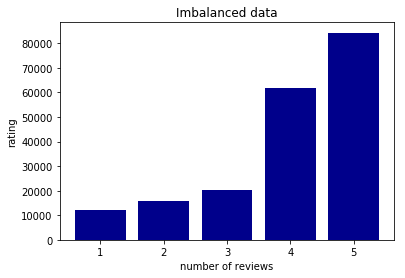

In [8]:
Train = load_train(DEFAULT_TRAIN_DATA_LOCATION)
i1=0
i2=0 
i3=0 
i4=0 
i5=0
for i in range(len(Train)):
    if Train[i][4] == 1:
        i1 += 1
    if Train[i][4] == 2:
        i2 += 1
    if Train[i][4] == 3:
        i3 += 1
    if Train[i][4] == 4:
        i4 += 1
    if Train[i][4] == 5:
        i5 += 1
print('Number of reviews with a rating of 1: '+str(i1))
print('Number of reviews with a rating of 2: '+str(i2))
print('Number of reviews with a rating of 3: '+str(i3))
print('Number of reviews with a rating of 4: '+str(i4))
print('Number of reviews with a rating of 5: '+str(i5))


import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5] 
  
# heights of bars 
height = [i1, i2, i3, i4, i5] 
  
# labels for bars 
tick_label = ['1', '2', '3', '4', '5'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['darkblue']) 
  
# naming the x-axis 
plt.xlabel('number of reviews') 
# naming the y-axis 
plt.ylabel('rating') 
# plot title 
plt.title('Imbalanced data') 
  
# function to show the plot 
plt.show() 

In [9]:
rating1=[]
rating2=[]
rating3=[]
rating4=[]
rating5=[]
for i in range(len(Train)):
    if Train[i][4] == 1:
        rating1.append(Train[i])
    if Train[i][4] == 2:
        rating2.append(Train[i])
    if Train[i][4] == 3:
        rating3.append(Train[i])
    if Train[i][4] == 4:
        rating4.append(Train[i])
    if Train[i][4] == 5:
        rating5.append(Train[i])

import random

random.shuffle(rating1)
random.shuffle(rating2)
random.shuffle(rating3)
random.shuffle(rating4)
random.shuffle(rating5)

subrating1 = rating1
subrating2 = rating2[0:len(rating1)]
subrating3 = rating3[0:len(rating1)]
subrating4 = rating4[0:len(rating1)]
subrating5 = rating5[0:len(rating1)]

subtrain = subrating1 + subrating2 + subrating3 + subrating4 + subrating5
random.shuffle(subtrain)

print(len(subtrain))

60395


### Make contentlist , rating list and Hotel_id list

In [10]:
#Train = subtrain
#Put the content of each review into a list
import random
random.shuffle(Train)

RealRating = list()
for i in range(len(Train)):
    if Train[i][4]!=-1:
        RealRating.append(Train[i])

Train = RealRating

content_list = list()

#for i in range(len(Train)):
 #   if Train[i][4]==str(-1):
 #       del Train[i]

for i in range(len(list(Train))):
    content=(list(list(Train[i]))[2])
    content_list.append(content)

rating_list = list()

for i in range(len(list(Train))):
    rating =list(Train[i])[4]
    rating = rating
    rating_list.append(rating)
    
Hotel_id_list = list()

for i in range(len(list(Train))):
    Hotel_id=(list(list(Train[i]))[6][0])
    Hotel_id_list.append(Hotel_id)

### Language detection: only English reviews

In [11]:
!pip install langdetect
from langdetect import detect
language = detect(content_list[0])
print(language)


notenglish = list()
nolanguage = list()
for i in range(len(content_list)):  #len(content_list)
    
    try:
    #language = detect(content_list[i])
        if( detect(content_list[i]) != 'en'):
            notenglish.append(i)
        
    except:
        nolanguage.append(i)
        
        
mergedlist = notenglish + nolanguage
print(mergedlist)

mergedlist.sort()
print(mergedlist)


times = 0
for i in range(len(mergedlist)): 
    content_list.pop(mergedlist[i] - times)
    rating_list.pop(mergedlist[i] - times)
    times = times + 1 

    

en
[4, 7, 12, 23, 38, 53, 54, 55, 71, 77, 85, 93, 99, 100, 118, 130, 143, 144, 150, 152, 162, 163, 165, 172, 180, 181, 183, 189, 196, 199, 207, 214, 217, 236, 248, 267, 269, 270, 271, 273, 281, 288, 289, 292, 294, 303, 308, 318, 325, 336, 345, 348, 349, 355, 357, 371, 374, 377, 378, 385, 391, 394, 404, 405, 406, 412, 421, 429, 442, 445, 450, 452, 463, 478, 480, 482, 483, 490, 496, 501, 507, 514, 516, 525, 531, 535, 538, 539, 543, 546, 553, 561, 577, 585, 586, 593, 610, 611, 614, 624, 625, 626, 636, 640, 657, 665, 672, 674, 684, 691, 694, 703, 705, 711, 713, 714, 719, 722, 725, 726, 729, 733, 744, 748, 752, 759, 774, 778, 785, 793, 798, 800, 803, 807, 808, 821, 832, 845, 849, 853, 860, 867, 879, 881, 884, 891, 894, 906, 907, 918, 935, 938, 946, 955, 968, 977, 987, 990, 996, 1000, 1005, 1006, 1028, 1031, 1034, 1037, 1041, 1050, 1051, 1053, 1057, 1090, 1096, 1103, 1105, 1111, 1113, 1131, 1134, 1136, 1145, 1154, 1163, 1177, 1187, 1189, 1195, 1196, 1207, 1217, 1220, 1223, 1225, 1235, 1240, 

In [12]:
len(notenglish)

31529

In [13]:
len(nolanguage)

574

### Lemitization

In [14]:
!pip install nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()

for i in range(len(content_list)):
    listlemmatizer = list()
    input_str = word_tokenize(content_list[i]) # Puts every word of the string situated in content_list[i] seperately into a list
    for word in input_str:
        lem = lemmatizer.lemmatize(word)
        listlemmatizer.append(lem)
    content_list[i] = ' '.join(listlemmatizer) # Puts the seperate words back into one string where the words are seperated by one space ' '
    
print(content_list[1:10])

["No Hyatt Touch Small Pool Heart of Congestion Hello if you are headed here you are headed to the only Waikiki hotel this end with two jacuzzis ! Now don ; t run over from Starwood acroos the street or they will run you away ! The pool however is no bigger than a standard pool table at your favorite arcade ! Speaking of fun get ready to play the same game you do with the local supermarket in their Gold Passport program ! See they give you a three page folio for a Three day stay with all these extra charge for in room coffee @ $ 1.38 USD per cup ! and a $ 20.00 breakfast buffet per person and a 3.50 safe charge and on and on . Don ; t expect a concierge or knowledgeable staff they have retreated to the Expedia Fun ! desk now if you are internet savvy you can save on activity by going to expedia.com but there is no one but Tommy at the desk that can explain the activity in detail to you . The staff look to economize and take short cut when ever possible . There is NO private beach ! The

### Define a vocabulary and only save those words in the content list

In [15]:

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

words = list()
for i in range(len(content_list)):
    input_str = word_tokenize(content_list[i])
    for word in input_str:
         words.append(word)
    
vocab = collections.Counter(words)

print(vocab.most_common(100))
print(vocab)

# keep tokens with a min occurrence
min_occurance = 100
word_bag = [k for k,c in vocab.items() if c >= min_occurance]
print(len(word_bag))

for i in range(len(content_list)): #len(content_list)
    tokens = word_tokenize(content_list[i])
    result = [w for w in tokens if w in word_bag]
    content_list[i] = ' '.join(result)
content_list[1:10]



[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[('the', 1657516), ('.', 1490181), (',', 1158654), ('and', 1039805), ('a', 947023), ('to', 772123), ('wa', 608341), ('in', 459231), ('of', 449787), ('I', 415486), ('is', 382155), ('for', 341389), ('The', 333514), ('hotel', 321859), ('we', 317094), ('room', 307526), ('it', 295115), ('!', 266473), ('at', 266092), ('you', 259475), ('were', 256037), ('with', 223314), ('on', 219587), ('that', 219224), ('but', 218790), ('not', 193499), ('very', 193114), ('We', 190455), ('had', 180154), ('are', 170290), (')', 167456), ('this', 165212), ('(', 161368), ('our', 156882), ('have', 153382), ('from', 146474), ('there', 130018), ("n't", 127441), ('they', 117313), ('be', 115579), ('all', 114574), ('great', 112705), ('would', 107571), ('so', 104747), ('stay', 104325), ('-', 101904), ('good', 99930), ('staff', 99927), ('my', 95221), ('night', 92419), ('did', 90087), ('one', 88636), ("'s", 83825), ('which', 82617), ('u', 82243), ('time', 81641), ('day', 80575), ('get', 76748), ('if', 76384), ('out', 7600

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



["No Hyatt Small Pool Heart of Hello if you are headed here you are headed to the only Waikiki hotel this end with two ! Now don ; t run over from Starwood the street or they will run you away ! The pool however is no bigger than a standard pool table at your favorite arcade ! Speaking of fun get ready to play the same game you do with the local supermarket in their Gold program ! See they give you a three page for a Three day stay with all these extra charge for in room coffee @ $ USD per cup ! and a $ 20.00 breakfast buffet per person and a 3.50 safe charge and on and on . Don ; t expect a concierge or knowledgeable staff they have to the Expedia Fun ! desk now if you are internet you can save on activity by going to but there is no one but at the desk that can explain the activity in detail to you . The staff look to and take short cut when ever possible . There is NO private beach ! The fitness center is at a charge unless it is with Gold membership and like Safeway supermarket you

### To dataframe

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


df = pd.DataFrame.from_dict(content_list)
df.columns = ['Review']
df.head(5)

df2 = pd.DataFrame.from_dict(rating_list)
df['Rating'] = df2

df['Hotel_id'] = pd.DataFrame.from_dict(Hotel_id_list, dtype = 'category')

df.head(20)



,Review,Rating,Hotel_id
0,Would return,4,937
1,No Hyatt Small Pool Heart of Hello if you are ...,1,840
2,"I 'm in love with this hotel , the best experi...",5,700
3,A perfect haven in a city ... We stayed at The...,5,532
4,Miami nice - Went to RIU Florida Beach for 10 ...,4,313
5,Nice central hotel that is good value We staye...,4,763
6,"Good value for money , fantastic location ! I ...",4,492
7,A real find in Boston I stayed at the Lenox wh...,5,1405
8,It is perfect This hotel is amazing ! No need ...,5,567
9,It is what it is ... .. at Villas del Mar,3,1372


### Some Preprocessing

In [17]:
!pip install nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()

review_lines = list()
lines = df['Review'].values.tolist()

for line in lines:   
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    review_lines.append(words)

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
df['review_lines'] = review_lines

In [19]:
total_reviews = df.loc[:,'Review'].values
max_length = max([len(s.split()) for s in total_reviews])

## Wikipedia Embedding

In [20]:
!pip install bz2file

import os
import bz2
embeddings_index = {}
#f = bz2.open("enwiki_20180420_win10_100d.txt.bz2", "rt")
f = bz2.open('enwiki_20180420_win10_100d.txt.bz2', mode='rt', compresslevel=9, encoding=None, errors=None, newline=None)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [21]:
len(df['Rating'])

164436

In [22]:
X_train = df.loc[:(len(df['Rating'])/2)-1,'Review'].values
len(X_train)
y_train = df.loc[:(len(df['Rating'])/2)-1, 'Rating'].values
X_test = df.loc[len(df['Rating'])/2:len(df['Rating']), 'Review'].values
y_test = df.loc[len(df['Rating'])/2:len(df['Rating']), 'Rating'].values

In [23]:
total_reviews = X_train + X_test
max_length = max([len(s.split()) for s in total_reviews])

## Split in train and validation data

In [24]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
print(df.head(5))

import numpy as np

# Group the reviews per hotel, and count how many reviews there are per hotel
reviews_per_hotel = df.groupby('Hotel_id').count().sort_values(by = 'Hotel_id',ascending=False)
# Select 3/4ths of the hotel indices to be in the train set, and the remaining 1/4th in the test set
train_idxs = np.random.choice(len(reviews_per_hotel), int(len(reviews_per_hotel)*3/4), replace=False)
test_idxs = [i for i in range(len(reviews_per_hotel)) if i not in train_idxs]
# Split the dataframe with the hotels and their resp. number of reviews into a train and a test part
hotels_train = reviews_per_hotel.iloc[train_idxs]
hotels_test  = reviews_per_hotel.iloc[test_idxs]
N_train = hotels_train.sum()
N_test = hotels_test.sum()
print('{} reviews in the train set, {} reviews in the validation set, fraction {}'.format(N_train, N_test, N_test / (N_train)))

# Create the train and validation set
df_train = df.loc[df['Hotel_id'].isin(list(hotels_train.index))].reset_index(drop=True)
df_val = df.loc[df['Hotel_id'].isin(list(hotels_test.index))].reset_index(drop=True)
'''
VALIDATION_SPLIT = 0.25
import numpy as np

# Group the reviews per hotel, and count how many reviews there are per hotel
reviews_per_hotel = df.groupby('Hotel_id').count().sort_values(by = 'Hotel_id',ascending=False)

print(reviews_per_hotel)
print(len(reviews_per_hotel))

hotels_train = reviews_per_hotel[0:int(len(reviews_per_hotel)*(1-VALIDATION_SPLIT))]
hotels_test  = reviews_per_hotel[int(len(reviews_per_hotel)*(1-VALIDATION_SPLIT)):len(reviews_per_hotel)]
N_train = hotels_train.sum()
N_test = hotels_test.sum()
#print(hotels_train.head(5))


#hotels_train = hotels_train.sample(frac=1)
#print(hotels_train.head(5))
#hotels_test = hotels_test.sample(frac=1)

df_train = df.loc[df['Hotel_id'].isin(list(hotels_train.index))].reset_index(drop=True)
df_val = df.loc[df['Hotel_id'].isin(list(hotels_test.index))].reset_index(drop=True)

df_train = df_train.sample(frac=1)
df_val = df_val.sample(frac=1)
'''
# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(df_train['review_lines'])
sequences = tokenizer_obj.texts_to_sequences(df_train['review_lines'])

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df_train['Rating'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

X_train_pad = review_pad
y_train = sentiment


# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(df_val['review_lines'])
sequences = tokenizer_obj.texts_to_sequences(df_val['review_lines'])

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df_val['Rating'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

X_test_pad  = review_pad
y_test = sentiment

#num_validation_samples = int(N_test[0])

#X_train_pad = review_pad[:-num_validation_samples]
#y_train = sentiment[:-num_validation_samples]
#X_test_pad = review_pad[-num_validation_samples:]
#y_test = sentiment[-num_validation_samples:]

                                              Review  Rating  Hotel_id  \
0                                       Would return       4       937   
1  No Hyatt Small Pool Heart of Hello if you are ...       1       840   
2  I 'm in love with this hotel , the best experi...       5       700   
3  A perfect haven in a city ... We stayed at The...       5       532   
4  Miami nice - Went to RIU Florida Beach for 10 ...       4       313   

                                        review_lines  
0                                    [would, return]  
1  [hyatt, small, pool, heart, hello, headed, hea...  
2  [love, hotel, best, experience, ever, could, a...  
3  [perfect, city, stayed, library, night, christ...  
4  [miami, nice, went, riu, florida, beach, days,...  
Review          124556
Rating          124556
review_lines    124556
dtype: int64 reviews in the train set, Review          39880
Rating          39880
review_lines    39880
dtype: int64 reviews in the validation set, fractio

In [26]:
print('Shape of X_train_pad tensor:', X_train_pad.shape)
print('Shape of y_train tensor:', y_train.shape)

print('Shape of X_test_pad tensor:', X_test_pad.shape)
print('Shape of y_test tensor:', y_test.shape)

Shape of X_train_pad tensor: (124556, 7888)
Shape of y_train tensor: (124556,)
Shape of X_test_pad tensor: (39880, 7888)
Shape of y_test tensor: (39880,)


Distribution of the ratings in the training set:
Number of reviews with a rating of 1: 8376
Number of reviews with a rating of 2: 10845
Number of reviews with a rating of 3: 12929
Number of reviews with a rating of 4: 37748
Number of reviews with a rating of 5: 54657


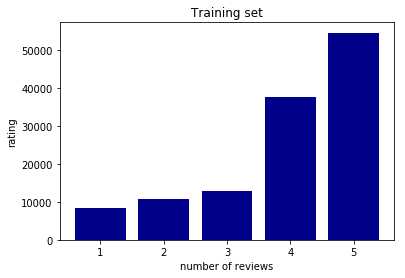

Distribution of the ratings in the validation set:
Number of reviews with a rating of 1: 2582
Number of reviews with a rating of 2: 3431
Number of reviews with a rating of 3: 4018
Number of reviews with a rating of 4: 12244
Number of reviews with a rating of 5: 17605


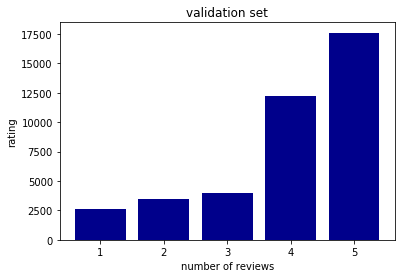

In [27]:

i1=0
i2=0 
i3=0 
i4=0 
i5=0
for i in range(len(y_train)):
    if y_train[i] == 1:
        i1 += 1
    if y_train[i] == 2:
        i2 += 1
    if y_train[i] == 3:
        i3 += 1
    if y_train[i] == 4:
        i4 += 1
    if y_train[i] == 5:
        i5 += 1
print('Distribution of the ratings in the training set:')
print('Number of reviews with a rating of 1: '+str(i1))
print('Number of reviews with a rating of 2: '+str(i2))
print('Number of reviews with a rating of 3: '+str(i3))
print('Number of reviews with a rating of 4: '+str(i4))
print('Number of reviews with a rating of 5: '+str(i5))


import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5] 
  
# heights of bars 
height = [i1, i2, i3, i4, i5] 
  
# labels for bars 
tick_label = ['1', '2', '3', '4', '5'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['darkblue']) 
  
# naming the x-axis 
plt.xlabel('number of reviews') 
# naming the y-axis 
plt.ylabel('rating') 
# plot title 
plt.title('Training set') 
  
# function to show the plot 
plt.show() 


i1=0
i2=0 
i3=0 
i4=0 
i5=0
for i in range(len(y_test)):
    if y_test[i] == 1:
        i1 += 1
    if y_test[i] == 2:
        i2 += 1
    if y_test[i] == 3:
        i3 += 1
    if y_test[i] == 4:
        i4 += 1
    if y_test[i] == 5:
        i5 += 1
print('Distribution of the ratings in the validation set:')
print('Number of reviews with a rating of 1: '+str(i1))
print('Number of reviews with a rating of 2: '+str(i2))
print('Number of reviews with a rating of 3: '+str(i3))
print('Number of reviews with a rating of 4: '+str(i4))
print('Number of reviews with a rating of 5: '+str(i5))


import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5] 
  
# heights of bars 
height = [i1, i2, i3, i4, i5] 
  
# labels for bars 
tick_label = ['1', '2', '3', '4', '5'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['darkblue']) 
  
# naming the x-axis 
plt.xlabel('number of reviews') 
# naming the y-axis 
plt.ylabel('rating') 
# plot title 
plt.title('validation set') 
  
# function to show the plot 
plt.show() 

In [23]:
y_test[1:10]

array([4, 1, 5, 3, 2, 4, 5, 5, 2])

**Set class weights for imbalanced classes**

In [103]:
from sklearn.utils import class_weight
class_weightstrain = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print(class_weightstrain.shape)
class_weightstrain

(5,)


array([ 2.91183295,  2.30910764,  1.94875776,  0.66122234,  0.4549574 ])

In [25]:
y_train[0:10]

array([5, 4, 2, 4, 5, 5, 1, 4, 3, 5])

In [34]:


#class_weightstrain = {"[ 0.,  0.,  0.,  0.,  0.]": 3.14275093,
#                "[ 0.,  1.,  0.,  0.,  0.]": 2.22473684,
#                "[ 0.,  0.,  1.,  0.,  0.]": 1.89127517,
#               "[ 0.,  0.,  0.,  1.,  0.]": 0.67470072,
#               "[ 0.,  0.,  0.,  0.,  1.]": 0.45015974}
               


In [29]:
EMBEDDING_DIM =100
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [28]:
!pip install numpy

## CuDNNLSTM model

In [27]:

from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.initializers import Constant
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import LSTM, CuDNNLSTM
np.random.seed(7)
from keras import regularizers
from keras import constraints
from keras.constraints import max_norm
#model_1_v3_savename = 'TripAdvisor_wikidembeddinglstm_model_MAE_alldata0.3.h5'

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(CuDNNLSTM(20,return_sequences=False, stateful = False, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
#Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
print(model.summary())
#callbacks = [
 #            ModelCheckpoint(model_1_v3_savename, monitor='val_mean_absolute_error', verbose=2, 
                             save_best_only=True)]
history = model.fit(X_train_pad, y_train, batch_size=256, epochs=40, validation_data=(X_test_pad, y_test),
                    class_weight=class_weightstrain,verbose=1, callbacks = callbacks)


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8509, 100)         674600    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 20)                9760      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 684,381
Trainable params: 9,781
Non-trainable params: 674,600
_________________________________________________________________
None
Train on 125022 samples, validate on 39391 samples
Epoch 1/40
125022/125022 [==============================] - 170s 1ms/step - loss: 1.1934 - mean_absolute_error: 1.1416 - val_loss: 0.9771 - val_mean_absolute_error: 0.9494

Epoch 00001: val_mean_absolute_erro

125022/125022 [==============================] - 164s 1ms/step - loss: 0.6584 - mean_absolute_error: 0.6285 - val_loss: 0.9057 - val_mean_absolute_error: 0.8758

Epoch 00029: val_mean_absolute_error improved from 0.89692 to 0.87583, saving model to TripAdvisor_wikidembeddinglstm_model_MAE_alldata0.3.h5
Epoch 30/40
125022/125022 [==============================] - 165s 1ms/step - loss: 0.6568 - mean_absolute_error: 0.6268 - val_loss: 0.9909 - val_mean_absolute_error: 0.9609

Epoch 00030: val_mean_absolute_error did not improve from 0.87583
Epoch 31/40
125022/125022 [==============================] - 164s 1ms/step - loss: 0.6544 - mean_absolute_error: 0.6243 - val_loss: 0.9141 - val_mean_absolute_error: 0.8841

Epoch 00031: val_mean_absolute_error did not improve from 0.87583
Epoch 32/40
125022/125022 [==============================] - 164s 1ms/step - loss: 0.6495 - mean_absolute_error: 0.6195 - val_loss: 0.9386 - val_mean_absolute_error: 0.9086

Epoch 00032: val_mean_absolute_error did n

In [28]:
model.load_weights(model_1_v3_savename)
score_val = model.evaluate(X_test_pad, y_test, verbose=0)
print('Validation MAE:', score_val[1])


Validation MAE: 0.875831034594


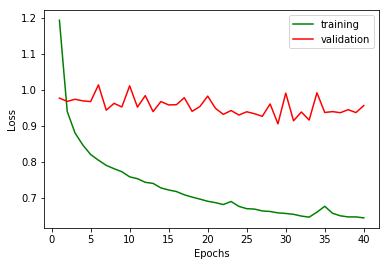

In [29]:


import matplotlib.pyplot as plt

real_epochs = 40

#real_epochs = len(history.history['acc'])
#plt.figure(figsize=(6, 4))
#plt.plot(np.arange(1,real_epochs+1,1),history.history['acc'],'g-',label='training')
#plt.plot(np.arange(1,real_epochs+1,1),history.history['val_acc'],'r-',label='validation')
#plt.xlabel("Epochs")
#plt.ylabel("Accuracy")
#plt.legend()

#plt.show()

#plt.figure()
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1,real_epochs+1,1),history.history['loss'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_loss'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [30]:
max_length

8509

## Confusion matrix on validation data

In [33]:
model.load_weights(model_1_v3_savename)
y_prediction = model.predict(X_test_pad)
test_predicted_class = np.around(y_prediction)
#for i in range(len(y_prediction)):
#    value = round(y_prediction[i])
#    test_predicted_class.append(value)

#y_prediction[0]

#test_predicted_class = np.argmax(y_prediction,axis=1)
#test_predicted_class[0]
#len(test_predicted_class)

#y_train = rating_list
#x_val = x_train[:round(0.3*len(Train))]
#y_val = y_train[:round(0.3*len(Train))]



In [34]:
# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(df_val['review_lines'])
sequences = tokenizer_obj.texts_to_sequences(df_val['review_lines'])

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df_val['Rating'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

X_test_pad  = review_pad
y_test2 = sentiment



print(y_prediction)
print(test_predicted_class)

Found 6744 unique tokens.
Shape of review tensor: (39880, 7888)
Shape of sentiment tensor: (39880,)
[[ 4.02429676]
 [ 4.00325489]
 [ 3.75869656]
 ..., 
 [ 3.99300051]
 [ 4.5687542 ]
 [ 2.94197059]]
[[ 4.]
 [ 4.]
 [ 4.]
 ..., 
 [ 4.]
 [ 5.]
 [ 3.]]


Confusion matrix, without normalization


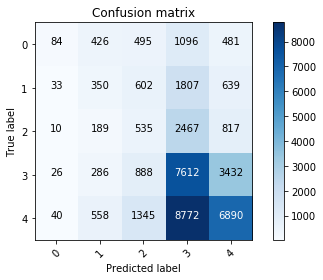

In [36]:

# You can use the code below to plot a confusion matrix


from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix(y_test2, test_predicted_class) #voor mae: ypredictions

## Misclassifications

In [37]:
for i in range(500):
    result1 = test_predicted_class[i]
    result2 = df_val.iloc[i][1]
    if (result1 != result2):
        print(" Predicted rating: ", result1, "\n", "True rating: ", result2 , "\n", "Review: ",df_val.iloc[i][0], "\n")

 Predicted rating:  [ 4.] 
 True rating:  5 
 Review:  It is perfect This hotel is amazing ! No need to write the same thing you will find in the other review . I will just touch on the internet service which I found to be excellent . I am not a person that need to be connected 24/7 but I needed to double check couple of flight reservation and any e-mail from my . Let me tell you that finding an Internet station in Venice is not that easy at all . So I wa very pleasantly surprise to be able to use the lobby computer on the second floor for free . Great hotel , great service and perfect location ! 

 Predicted rating:  [ 2.] 
 True rating:  4 
 Review:  Overall positive experience Stayed one night , Saturday , two room . My wife and 4 kid ranging from in age . Quick , efficient check-in process . Decent ( average to slightly above ) size room . Bathroom is much larger than what you 'd usually find at this . Quiet . Comfy bed a advertised . $ per room ( each w/ two double bed ) with all 

 Predicted rating:  [ 4.] 
 True rating:  5 
 Review:  Great Price Stayed at Monteleone from for three night , Hotel staff top notch in every way . The place wa super clean , staff a pleasure to talk to , 5 star place at 1 star price . Cant beat location one block south of Bourbon Street . 

 Predicted rating:  [ 4.] 
 True rating:  5 
 Review:  Great staff I stayed at the Park Plaza a part of a tour group . The stay wa fantastic from start to finish . Every member of staff did absolutely everything possible to make u welcome . A big thank you to and her staff at The First Bar for their impeccable service each night . Rooms are of a very good standard with plenty of space and full kit of amenity in the bathroom . You can use the wired internet in your room or the wifi at the area , both are free . All in all I would definitely recommend the Park Plaza if you are travelling to Beijing . 

 Predicted rating:  [ 4.] 
 True rating:  3 
 Review:  Good budget hotel in a great location View o

 True rating:  5 
 Review:  Going for A really stunning hotel , beautifully maintained . I love the way the floor rug are fitted into the floor , so that you do n't trip over them . This is where I go for a splurge , and I book a room which ha all the lovely antique fitting . My husband loved the big spacious desk . Close enough to and the Store with it fabulous basement ( great if you like Japanese food at reasonable price ) , but also quite central for the historic , colonial district . It is within walking distance of the old church and Raffles hotel , and close to the and the area . There are many cheaper hotel , but this is the place for ! 

 Predicted rating:  [ 5.] 
 True rating:  2 
 Review:  bar price - even wore a mask ! not a 4 star hotel , the hotel ha no soul . the only saving grace were the staff who were very and . after we check out we retired to the bar to our departure for the airport and ordered 4 local beer ' . We were presented with a bill for 鈧 ? 8 ( $ 50 ) , an r